In [2]:
import scipy.io
from io import BytesIO
import requests
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [3]:
# Load data
url = 'https://github.com/yao-lab/yao-lab.github.io/raw/master/data/face.mat' 
response = requests.get(url) 
face_data = scipy.io.loadmat(BytesIO(response.content))
print(face_data.keys())
images = face_data['Y']
print(images.shape)
x = np.reshape(images, [10304, 33]).T
print(x.shape)


dict_keys(['__header__', '__version__', '__globals__', 'Y', 'id'])
(112, 92, 33)
(33, 10304)


In [4]:
# function for image scatter plot after embedding
def image_scatter(imgs, y_emb, axs, scale=0.3):
    # draw points one by one
    for i in range(y_emb.shape[1]):
        img = imgs[:, :, i]
        imagebox = OffsetImage(img, zoom=scale, cmap='gray')
        ab = AnnotationBbox(imagebox, (y_emb[0, i], y_emb[1, i]), frameon=False)
        axs.add_artist(ab)


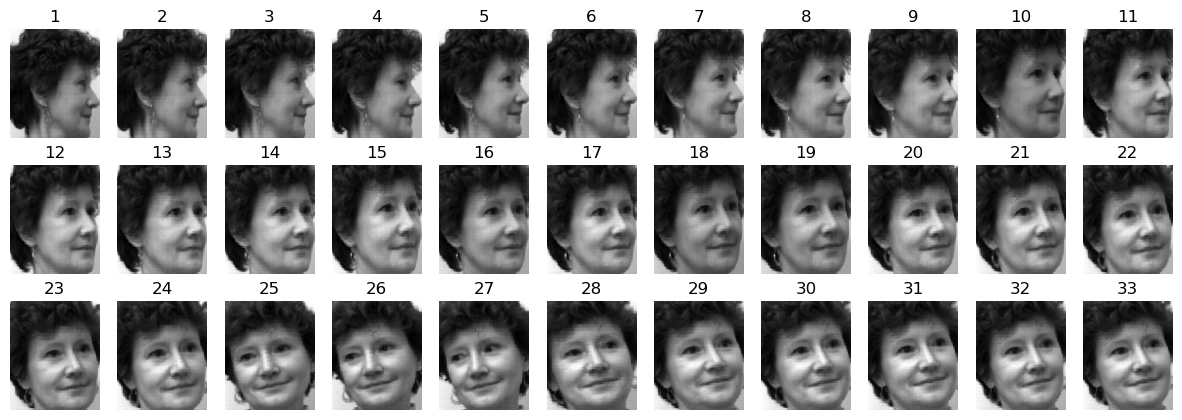

In [5]:
# Show image in default order
img_id = face_data['id'][0].copy()
ordered_idx = np.argsort(img_id)

fig, axs = plt.subplots(3, 11, figsize=(15, 5))
axs = axs.flatten()
for i in range(33):
    axs[i].imshow(images[:, :, ordered_idx[i]], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(img_id[ordered_idx[i]]))


# LSTA

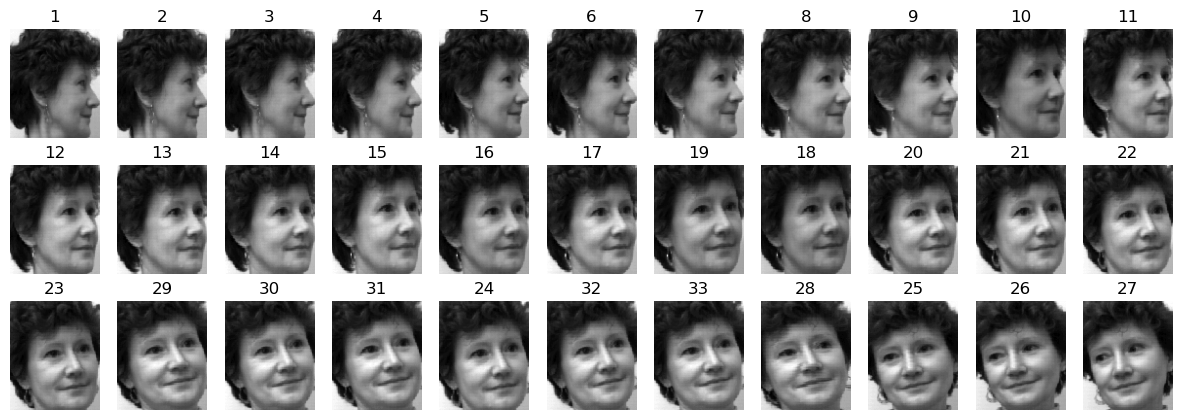

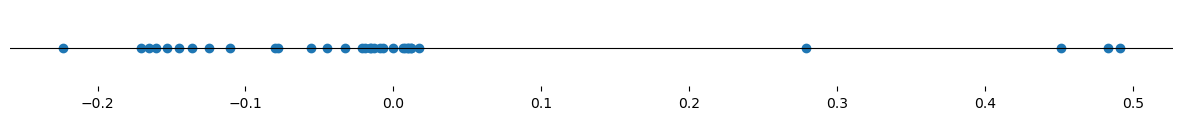

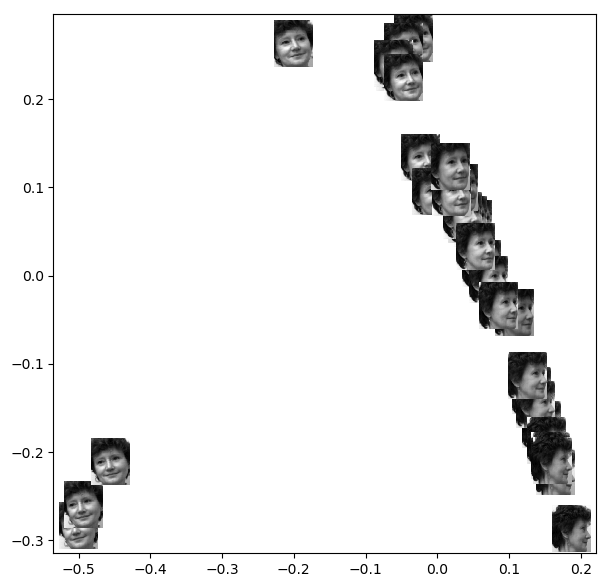

In [27]:
from sklearn.manifold import LocallyLinearEmbedding

k = 5
ltsa = LocallyLinearEmbedding(n_neighbors=k, n_components=1, method='ltsa')
y_lsta = ltsa.fit_transform(x).T

ltsa_2d = LocallyLinearEmbedding(n_neighbors=k, n_components=2, method='ltsa')
y_lsta_2d = ltsa_2d.fit_transform(x).T


# Visualize LTSA-embedding for 1D and 2D case
# 1D
fig, axs = plt.subplots(3, 11, figsize=(15, 5))
axs = axs.flatten()
x_lsta = y_lsta[0]
idx = np.argsort(x_lsta)
lsta_ordered = img_id[idx]  # save the order for later comparison
for i in range(33):
    axs[i].imshow(images[:, :, idx[i]], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(img_id[idx[i]]))

fig_1d, axs_1d = plt.subplots(1, 1, figsize=(15, 1))
axs_1d.scatter(x_lsta[idx], [0 for i in range(len(idx))])
axs_1d.axhline(0, color='black',linewidth=0.8)
axs_1d.set_yticks([])
axs_1d.spines['left'].set_visible(False)
axs_1d.spines['right'].set_visible(False)
axs_1d.spines['top'].set_visible(False)
axs_1d.spines['bottom'].set_visible(False)

# 2D
fig_2d, axs_2d = plt.subplots(1, 1, figsize=(7, 7))
axs_2d.scatter(y_lsta_2d[0], y_lsta_2d[1], c='g', marker='o')
# Set the image for each point
image_scatter(imgs=images, y_emb=y_lsta_2d, axs=axs_2d)



# 2D t-SNE

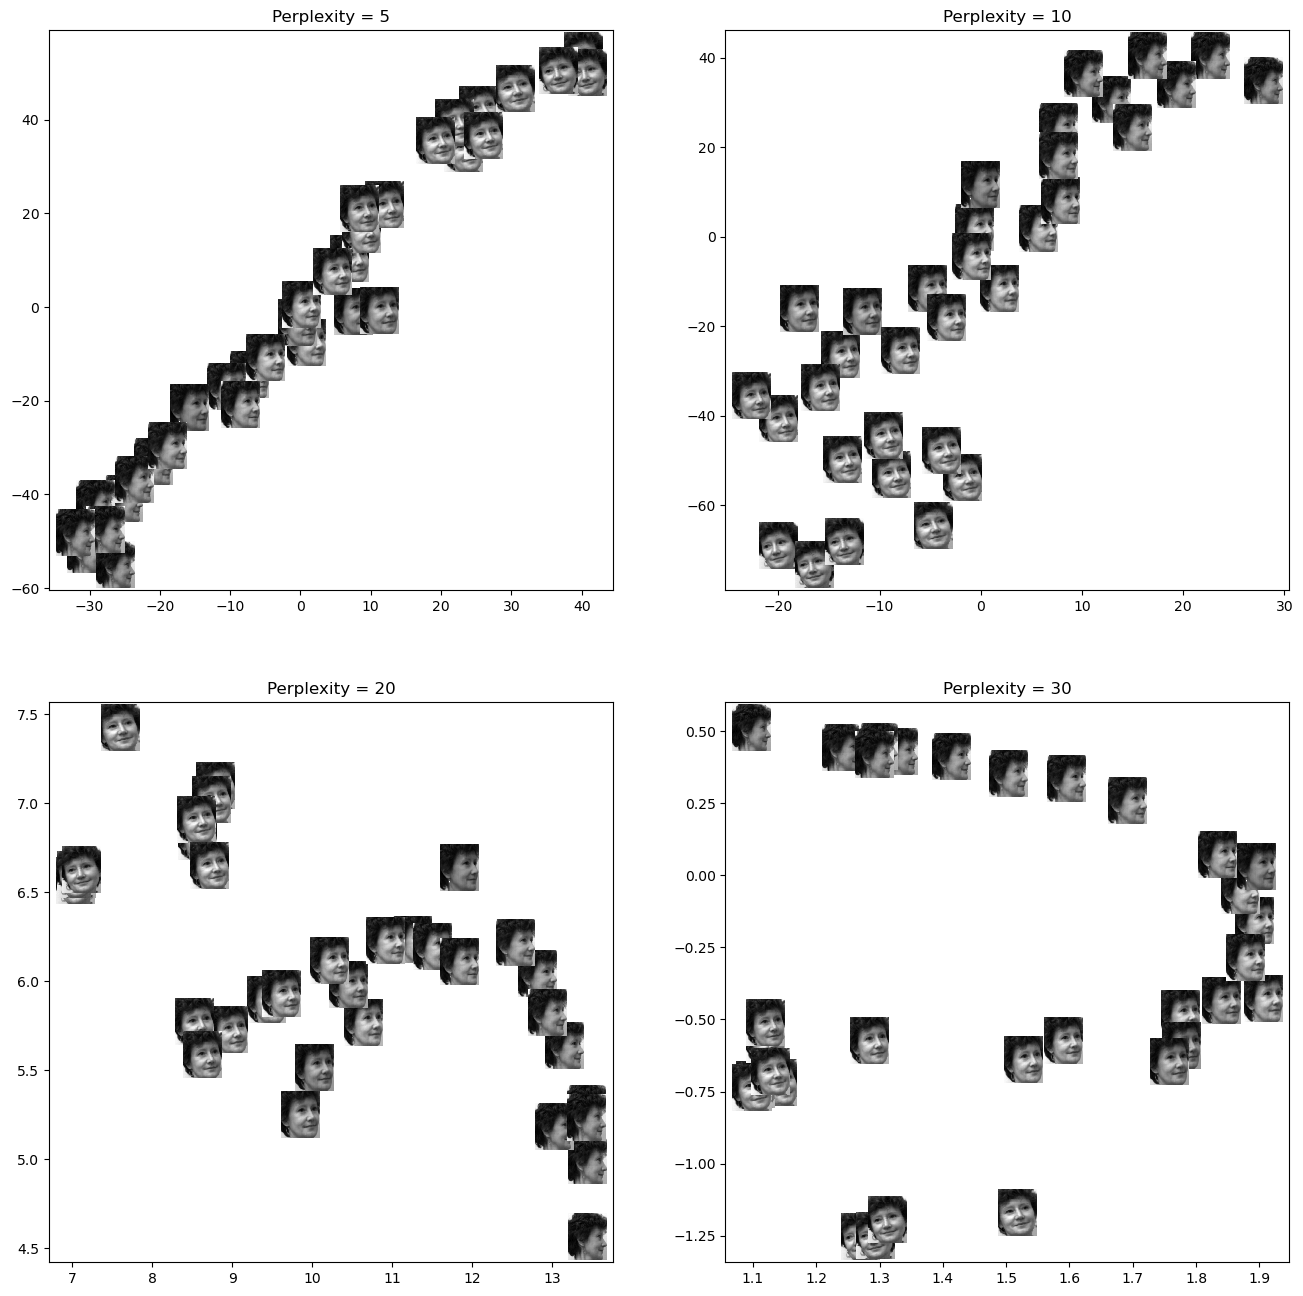

In [31]:
from sklearn.manifold import TSNE

# 2-d t-sne embedding of the 33 faces

perplexitys = [5, 10, 20, 30]

# Visualize 2-d t-sne embedding of the 33 faces

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
axs = axs.flatten()

for i, perplexity in enumerate(perplexitys):

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', n_iter=2000, init='pca', random_state=42)
    y_tsne = tsne.fit_transform(x).T
    axs[i].scatter(y_tsne[0], y_tsne[1], c='g', marker='o')
    image_scatter(imgs=images, y_emb=y_tsne, axs=axs[i])
    axs[i].set_title('Perplexity = {}'.format(perplexity))

    # Save the order for later comparison for perplexity == 5
    if perplexity == 5:
        tsne_ordered_x = img_id[np.argsort(y_tsne[0])]
        tsne_ordered_y = img_id[np.argsort(y_tsne[1])]


# Correspondence between two rankings

In [32]:
from scipy.stats import kendalltau

# Calculate Kendall's Tau
gt = np.sort(img_id)

lsta_tau, lsta_p = kendalltau(lsta_ordered, gt)
print('LSTA')
print(f"Kendall's Tau: {lsta_tau:.3f}")
print(f"P-value: {lsta_p:.3f}")

# 2D t-SNE oreder along two axis with perplexity 5
tsne_tau_x, tsne_p_x = kendalltau(tsne_ordered_x, gt)
tsne_tau_y, tsne_p_y = kendalltau(tsne_ordered_y, gt)
print('t-SNE')
print(f"Kendall's Tau (x): {tsne_tau_x:.3f}")
print(f"P-value (x): {tsne_p_x:.3f}")
print(f"Kendall's Tau (y): {tsne_tau_y:.3f}")
print(f"P-value (y): {tsne_p_y:.3f}")

LSTA
Kendall's Tau: 0.898
P-value: 0.000
t-SNE
Kendall's Tau (x): 0.837
P-value (x): 0.000
Kendall's Tau (y): 0.875
P-value (y): 0.000
